In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import time
#from logger import Logger

In [2]:
train_data = torchvision.datasets.FashionMNIST(root='', train=True, download=False,
                                               transform=transforms.Compose([transforms.Grayscale(),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

In [3]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)

9


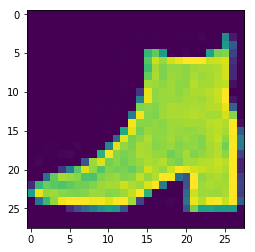

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
view_data = iter(train_loader)
images, labels = view_data.next()
plt.imshow((images[0][0]/2 + 0.5).numpy())
print(labels[0])

In [201]:
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=(3,3), padding=0)   #30
        nn.init.xavier_uniform(self.conv1.weight)
        self.pool = nn.MaxPool2d((2,2),padding=1, stride=1)
        self.batch_norm1 = nn.BatchNorm2d(50)
        self.conv2 = nn.Conv2d(50, 50, kernel_size=(3,3), padding=1)   #30
        nn.init.xavier_uniform(self.conv2.weight)
        self.batch_norm2 = nn.BatchNorm2d(50)
        self.conv3 = nn.Conv2d(50, 50, kernel_size=(3,3), padding=1)    #30
        nn.init.xavier_uniform(self.conv3.weight)
        self.batch_norm3 = nn.BatchNorm2d(50)
        self.conv4 = nn.Conv2d(50, 50, kernel_size=(3,3), padding=1)    #30
        nn.init.xavier_uniform(self.conv4.weight)
        self.batch_norm4 = nn.BatchNorm2d(50)
        self.conv5 = nn.Conv2d(50, 20, kernel_size=(2,2), padding=1)
        nn.init.xavier_uniform(self.conv5.weight)
        self.batch_norm5 = nn.BatchNorm2d(20)
        self.conv6 = nn.Conv2d(20, 5, kernel_size=(2,2), padding=1)
        nn.init.xavier_uniform(self.conv6.weight)
        self.batch_norm6 = nn.BatchNorm2d(5)
#        self.fc1 = nn.Linear(23520, 5000)
#        nn.init.xavier_uniform(self.fc1.weight)
#        self.fc2 = nn.Linear(5000, 800)
#        nn.init.xavier_uniform(self.fc2.weight)
#        self.fc3 = nn.Linear(800, 100)
#        nn.init.xavier_uniform(self.fc3.weight)
#        self.fc4 = nn.Linear(100,10)
#        nn.init.xavier_uniform(self.fc4.weight)
        
        self.fc1 = nn.Linear(4500, 800)
        nn.init.xavier_uniform(self.fc1.weight)
#        self.fc2 = nn.Linear(5000, 800)
#        nn.init.xavier_uniform(self.fc2.weight)
        self.fc2 = nn.Linear(800, 100)
        nn.init.xavier_uniform(self.fc2.weight)
        self.fc3 = nn.Linear(100,10)
        nn.init.xavier_uniform(self.fc3.weight)
        
    def forward(self, x):
        x = self.pool(self.batch_norm1(F.leaky_relu(self.conv1(x))))
        x = self.pool(self.batch_norm2(F.leaky_relu(self.conv2(x))))
        x = self.batch_norm3(F.leaky_relu(self.conv3(x)))
        x = self.batch_norm4(F.leaky_relu(self.conv4(x)))
        x = self.batch_norm5(F.leaky_relu(self.conv5(x)))
        x = self.batch_norm6(F.leaky_relu(self.conv6(x)))
        x = x.view(-1, 4500)
        x = F.leaky_relu(self.fc1(x))
        x = F.dropout(x, p=0.4)
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.4)
        x = F.leaky_relu(self.fc3(x))
        x = F.dropout(x, p=0.4)
        return x



In [203]:
conv_net = Conv_Net()
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load('Seventh_run:params', map_location=lambda storage, loc:storage)
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
conv_net.load_state_dict(new_state_dict)

In [107]:
optimizer = torch.optim.Adam(conv_net.parameters(), lr=0.000005, betas=(0.5, 0.999))
Loss = nn.CrossEntropyLoss()


if torch.cuda.is_available():
    conv_net = nn.DataParallel(conv_net)
    conv_net.cuda()
    

In [108]:
epoch_loss_data = []
zero = time.time()
for i in range(20):
    epoch_loss = 0.0
    start = time.time()
    for i, element in enumerate(train_loader):

        images, labels = element
        
        images, labels = Variable(images), Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = conv_net(images)
                
        loss = Loss(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss+=loss
        
        if i%100==0:
            print(i, 'done', loss.data[0])
    end = time.time()
    print('Epoch training time: ', end-start)
    epoch_loss_data.append(epoch_loss)
end = time.time()
print('Total training time: ', end - zero)


#The networks were trained through the bash kernel, and the model, running_loss and epoch_losses were saved 
#in pickle files

0 done 0.2495584338903427


KeyboardInterrupt: 

In [58]:
test_data = torchvision.datasets.FashionMNIST(root='', train=False, download=False,
                                               transform=transforms.Compose([transforms.Grayscale(),
                                                                            transforms.ToTensor(),
                                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = DataLoader(test_data, batch_size = 64, drop_last=True)

In [204]:
total = 0
correct =0
for i, element in enumerate(test_loader):

    images, labels = element

    images, labels = Variable(images), Variable(labels)

    optimizer.zero_grad()

    outputs = conv_net(images)

    _, predicted = torch.max(outputs.data, 1)

    if i==0:
        final_outputs = outputs.data
        final_predictions = predicted
        all_labels = labels.data
    else:
        final_outputs = torch.cat([final_outputs, outputs.data], 0)
        final_predictions = torch.cat((final_predictions, predicted), 0)
        all_labels = torch.cat((all_labels, labels.data), 0)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()

In [74]:
import sklearn.metrics

In [191]:
epoch_loss_data = torch.load('first_run:epoch_loss', map_location=lambda storage, loc: storage)

In [210]:
loss = torch.load('first_run:running_loss')
print('Accuracy: ', 100*(correct/total))

Accuracy:  87.9306891025641


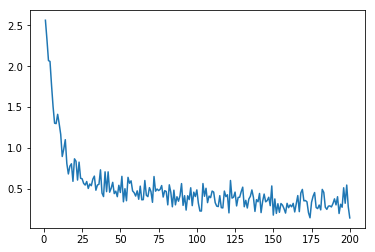

In [189]:
plt.plot(np.arange(1,len(loss)+1), loss)

In [200]:
#Models:
#First 86       ---> Residual + pooling(after every layer) + batch_norm(after_every_layer) + dropout(0.4)| Trainnig time : 9952s
#Second 89      ---> Residual(one skip after first convolution) + pooling(only first two layers to avoid loss of features at 
#               ---> third and fourth layers) + batch_norm + dropout | Training time : 9730s
#Third 86       ---> 6 Conv layers + pool(only first two layers) + 3(fc+leaky_relu) + dropout(0.4) + batch_norm | Training time : 4932s
#Fourth 85      ---> 6 Conv layers + pool(only first two layers) + 3(fc+relu) + dropout(0.1) + batch_norm |Training time : 4784s
#Fifth 87       ---> 6 Conv layers + pool(only first two layers) + 3(fc+elu) + dropout(0.4) + batch_norm + scheduled lr | Training time : 4897s
#sixth 87.5     ---> 6 Conv layers + pool(only first two layers) + 3(fc+elu) + dropout(0.4) + batch_norm | Training time : 4916s
#seven 88(87.93)       ---> 6 Conv layers + pool(only first two layers) + 3(fc+elu) + dropout(0.4) + batch_norm + xavier_initialisation | Training time : 4909s
#Eighth 87.28   ---> 4 Conv layers + 2 pool + 4(fc + relu) + dropout(0.4) + batch_norm | Training time : 3479s
#Nineth 87.34   ---> 4 Conv layers + 2 pool + 4(fc + elu) + dropout(0.4) + batch_norm | Training time : 3391s
#Tenth 86.6     ---> 4 Conv layers + 4 pool + 4(fc + elu) + dropout(0.4) + batch_norm | Training time : 3380s
#Eleventh 86.32 ---> 4 Conv layers + 4 pool + 4(fc + relu) + dropout(0.4) + batch_norm | Training time : 3421s

#All models were evaluated for either 10, 20 or 30 depending on the decrease in their losses

In [205]:
#epoch_loss_data = torch.cat((epoch_loss_data, epoch_loss_data2),0)
#plt.plot(np.arange(1,len(epoch_loss_data)), epoch_loss_data.data)
import pandas as pd
import seaborn as sns
%matplotlib inline
sklearn.metrics.confusion_matrix(final_predictions, all_labels)

array([[861,   4,  20,  43,   0,   0, 159,   0,   4,   0],
       [  3, 968,   1,  20,   3,   0,   2,   0,   4,   0],
       [ 14,   2, 855,  20, 124,   0, 105,   0,   7,   0],
       [  7,  11,   4, 829,  11,   2,  11,   0,   1,   0],
       [  6,   6,  68,  45, 803,   0,  87,   0,   1,   0],
       [  0,   1,   0,   0,   0, 966,   0,  13,   4,   9],
       [103,   3,  51,  40,  56,   0, 623,   0,  12,   1],
       [  0,   0,   0,   0,   0,  18,   0, 956,   4,  30],
       [  6,   2,   0,   2,   2,   1,  12,   0, 960,   0],
       [  0,   0,   0,   0,   0,  10,   0,  30,   0, 958]])

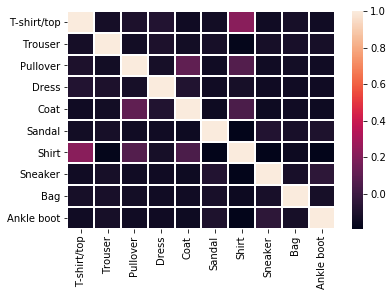

In [206]:
con_matrix = sklearn.metrics.confusion_matrix(final_predictions, all_labels)
con_matrix = pd.DataFrame(con_matrix)
con_matrix = con_matrix.corr()
sns.heatmap(con_matrix, xticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                                                    'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
            yticklabels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                                                    'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], linecolor='white', linewidth=1)


In [209]:
print(sklearn.metrics.classification_report(final_predictions, all_labels))

             precision    recall  f1-score   support

          0       0.86      0.79      0.82      1091
          1       0.97      0.97      0.97      1001
          2       0.86      0.76      0.80      1127
          3       0.83      0.95      0.88       876
          4       0.80      0.79      0.80      1016
          5       0.97      0.97      0.97       993
          6       0.62      0.70      0.66       889
          7       0.96      0.95      0.95      1008
          8       0.96      0.97      0.97       985
          9       0.96      0.96      0.96       998

avg / total       0.88      0.88      0.88      9984



In [208]:
sklearn.metrics.recall_score(all_labels, final_predictions, average='micro')

0.87930689102564108